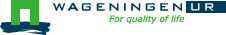



# Getting Started with PCSE/WOFOST

This Jupyter notebook will introduce PCSE and explain the basics of running models with PCSE, taking WOFOST as an example.

Allard de Wit, March 2018

**Prerequisites for running this notebook**

Several packages need to be installed for running PCSE/WOFOST:

  1. `PCSE` and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. `pandas` for processing and storing WOFOST output;
  3. `matplotlib` for generating charts


## Importing the relevant modules


In [1]:
%matplotlib inline
import sys, os
import pcse
import pandas
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.5.5


## Starting from the internal demo database
For demonstration purposes, we can start WOFOST with a single function call. This function reads all relevant data from the internal demo databases. In the next notebook we will demonstrate how to read data from external sources.

The command below starts WOFOST in potential production mode for winter-wheat for a location in Southern Spain.

In [2]:
wofostPP = pcse.start_wofost(mode="pp")

c:\Users\abdel\anaconda3\envs\abtest\lib\site-packages\pcse\db\pcse\db_input.py:652: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = select([table_site],
c:\Users\abdel\anaconda3\envs\abtest\lib\site-packages\pcse\db\pcse\db_input.py:127: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = s.execute()
c:\Users\abdel\anaconda3\envs\abtest\lib\site-packages\pcse\db\pcse\db_input.py:183: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors an

You have just successfully initialized a PCSE/WOFOST object in the Python interpreter, which is in its initial state and waiting to do some simulation. We can now advance the model state for example with 1 day:


In [3]:
wofostPP.run()

Advancing the crop simulation with only 1 day, is often not so useful so the number of days to simulate can be specified as well:

In [4]:
wofostPP.run(days=10)

## Getting information about state and rate variables
Retrieving information about the calculated model states or rates can be done with the `get_variable()` method on a PCSE object. For example, to retrieve the leaf area index value in the current model state you can do:

In [5]:
wofostPP.get_variable("LAI")

0.2870809817505803

In [6]:
wofostPP.run(days=25)
wofostPP.get_variable("LAI")

1.5281221557442748

Showing that after 11 days the LAI value is 0.287. When we increase time with another 25 days, the LAI increases to 1.528. The `get_variable()` method can retrieve any state or rate variable that is defined somewhere in the model. 

Finally, we can finish the crop season by letting it run until the model terminates because the crop reaches maturity or the harvest date:

In [7]:
wofostPP.run_till_terminate()

Note that before or after the crop cycle, the object representing the crop does not exist and therefore retrieving a crop related variable results in a `None` value. Off course the simulation results are stored and can be obtained, see next section.

In [8]:
print(wofostPP.get_variable("LAI"))

None


## Retrieving and displaying WOFOST output
We can retrieve the results of the simulation at each time step using  `get_output()`. In python terms this returns a list of dictionaries, one dictionary for each time step of the the simulation results. Each dictionary contains the key:value pairs of the state or rate variables that were stored at that time step.



In [9]:
output = wofostPP.get_output()

The most convenient way to handle the output from WOFOST is to used the `pandas` module to convert it into a dataframe. Pandas DataFrames can be converted to a variety of formats including excel, CSV or database tables.

In [10]:
dfPP = pandas.DataFrame(output).set_index("day")
dfPP.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2000-05-27,1.934169,0.0,18091.006102,8729.399813,3126.21567,6235.390619,1613.465879,0.0,60.0,0.3175,None
2000-05-28,1.953874,0.0,18091.006102,8729.399813,3126.21567,6235.390619,1613.465879,0.0,60.0,0.3175,None
2000-05-29,1.974056,0.0,18091.006102,8729.399813,3126.21567,6235.390619,1613.465879,0.0,60.0,0.3175,None
2000-05-30,1.995758,0.0,18091.006102,8729.399813,3126.21567,6235.390619,1613.465879,0.0,60.0,0.3175,None
2000-05-31,2.000000,0.0,18091.006102,8729.399813,3126.21567,6235.390619,1613.465879,0.0,60.0,0.3175,None


Besides the output at each time step, WOFOST also provides summary output which summarizes the crop cycle and provides you the total crop biomass, total yield, maximum LAI and other variables. In case of crop rotations, the summary output will consist of several sets of variables, one for each crop cycle.

In [11]:
summary_output = wofostPP.get_summary_output()
msg = "Reached maturity at {DOM} with total biomass {TAGP:.1f} kg/ha, " \
      "a yield of {TWSO:.1f} kg/ha with a maximum LAI of {LAIMAX:.2f}."
for crop_cycle in summary_output:
    print(msg.format(**crop_cycle))

Reached maturity at 2000-05-31 with total biomass 18091.0 kg/ha, a yield of 8729.4 kg/ha with a maximum LAI of 6.23.


## Visualizing output
The pandas module is also very useful for generating charts from simulation results. In this case we generate graphs of leaf area index and crop biomass including total biomass and grain yield.

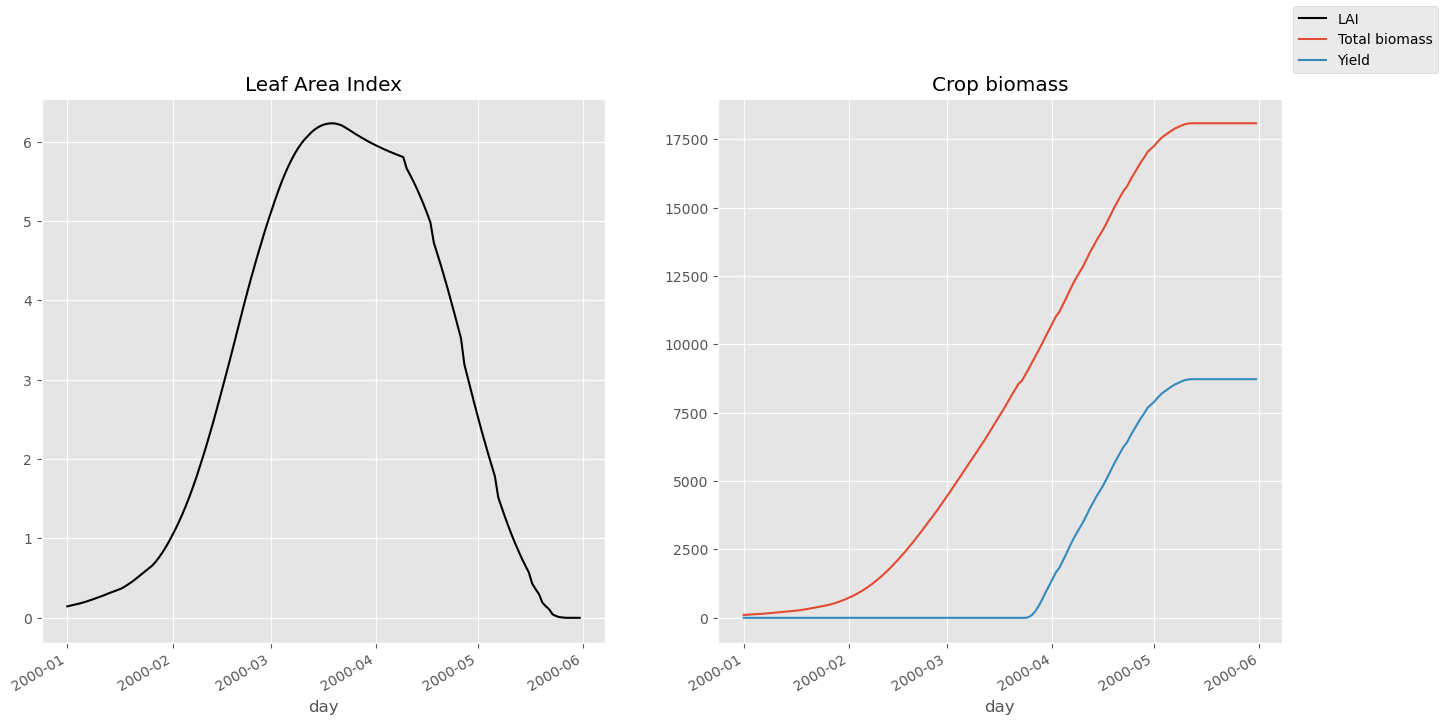

In [12]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
dfPP.LAI.plot(ax=axis1, label="LAI", color='k')
dfPP.TAGP.plot(ax=axis2, label="Total biomass")
dfPP.TWSO.plot(ax=axis2, label="Yield")
axis1.set_title("Leaf Area Index")
axis2.set_title("Crop biomass")
fig.autofmt_xdate()
r = fig.legend()